In [1]:
import gru2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from utils import *
import matplotlib.pyplot as plt
import math

batch_size = 32
n_iters = 6000
# num_epochs = n_iters / (len(train_dataset) / batch_size)
# num_epochs = int(num_epochs)
num_epochs = 20

input_dim_cnn = 20
input_dim = 36 #12
hidden_dim = 128
layer_dim = 1  
output_dim = 3
seq_dim = 20

# model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model = gru2.GRUDModel(input_dim_cnn, input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
# loss function and optimizer
# criterion = nn.MSELoss()  # regression
criterion = nn.CrossEntropyLoss()  # classification (包含softmax)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train_loss_list = []
val_loss_list = []

In [2]:
def test(data, X_data, Y_data, model, batch_size):
    model.eval()
    total_loss = 0
    n_samples = 0
    predict = None
    test = None
    predict_list = None
    test_list = None
    for X, Y in data.get_batches(X_data, Y_data, batch_size, False):
        output = model(X[:,:, input_dim*3:], X[:,:,:input_dim], X[:,:,input_dim:input_dim*2], X[:,:,input_dim*2:input_dim*3])
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))
    
#     print(test.shape,predict.shape)
#     x_axis = [x+1 for x in range(len(predict))]
#     plt.plot(x_axis,predict.cpu().detach().numpy() ,x_axis,test.cpu().detach().numpy() )
#     plt.show()
    predict = [x.index(max(x)) for x in predict.tolist()]
    result = {0:[0,0],1:[0,0],2:[0,0]}
    test = test.tolist()
    for i in range(len(predict)):
        if test[i][0] == predict[i]:
            result[test[i][0]][1] += 1
        result[test[i][0]][0] += 1
    print(result)
    

In [3]:
def loss_graph():
    x_axis = [x+1 for x in range(len(train_loss_list))]
    plt.plot(x_axis,train_loss_list,x_axis,val_loss_list)
    plt.show()

In [4]:
def evaluate(data, X_data, Y_data, model, criterion, batch_size):
    model.eval()
    total_loss = 0
    n_samples = 0
    predict = None
    test = None
    for X, Y in data.get_batches(X_data, Y_data, batch_size, False):
        output = model(X[:,:, input_dim*3:], X[:,:,:input_dim], X[:,:,input_dim:input_dim*2], X[:,:,input_dim*2:input_dim*3])
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))
        
        # Y = torch.tensor(Y, dtype=torch.long).clone().cuda().squeeze()
        Y = Y.long().resize(Y.size()[0])
        total_loss += float(criterion(output, Y))
        # n_samples += (output.size(0) * data.m)
        n_samples += (output.size(0) * 1)
    val_loss_list.append(total_loss / n_samples)
    return total_loss/n_samples

In [5]:
def train(data, X_data, Y_data, model, criterion, optim, batch_size):
    model.train()
    total_loss = 0
    n_samples = 0
    for X, Y in data.get_batches(X_data, Y_data, batch_size, True):
        model.zero_grad()
        output = model(X[:,:, input_dim*3:], X[:,:,:input_dim], X[:,:,input_dim:input_dim*2], X[:,:,input_dim*2:input_dim*3])

        # Y = torch.as_tensor(Y, dtype=torch.long).cuda().squeeze()
#         print(output.shape,Y.shape)
        # print(output,Y)
        Y = Y.long().resize(Y.size()[0])
        loss = criterion(output, Y)
        loss.backward()
        optim.step()
        total_loss += float(loss.data)  # adjust
        n_samples += (output.size(0) * 1)
    train_loss_list.append(total_loss / n_samples)
    return total_loss / n_samples

(26390, 129)
1 0.03426129752163838 0.034308301223949955
2 0.03425942358972457 0.03431245255199346
3 0.03425735973068458 0.03431147201494737
4 0.034256689622005586 0.034309891963546925
5 0.03425493214036922 0.034312371679327706
6 0.03425286822687504 0.034315018274567344
7 0.03425115843803019 0.03430626186457547
8 0.03424928015885718 0.034308845576914875
9 0.034248156673698585 0.03430664544755762
10 0.03424536232990051 0.03431879498741843
11 0.0342436317123294 0.03431198546832258
12 0.034243364283282535 0.03431283862753348
13 0.034241389229944734 0.034311881295659326
14 0.034239342437754304 0.034317361983385954
15 0.0342385957438001 0.034317971495064825
16 0.03423564635532003 0.03433400064706802
17 0.034236229019651496 0.0343095101416111
18 0.03423361887621435 0.03430494118820537
19 0.03422991649524586 0.034313543167981235
20 0.034230461731399923 0.0343188752098517


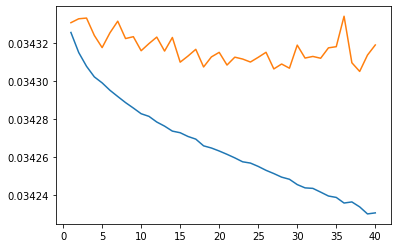

{0: [2860, 1193], 1: [3053, 762], 2: [2887, 1033]}


In [8]:
Data = Data_utility('./data/stock_company_feature_week.txt', 0.6, 0.2, True, 2, 1)

for epoch in range(1,num_epochs+1):
#     print(Data.train[0].shape,Data.train[1].shape)
    train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optimizer, batch_size)
    val_loss = evaluate(Data, Data.valid[0], Data.
                        valid[1], model, criterion, batch_size)
#     if epoch % 10 == 0:
    print(epoch,train_loss,val_loss)
loss_graph()
test(Data, Data.valid[0], Data.valid[1], model, batch_size)
# test_loss = evaluate(Data, Data.test[0], Data.test[1], model, criterion, batch_size)
# print(test_loss)




In [9]:
test(Data, Data.test[0], Data.test[1], model, batch_size)

{0: [2957, 1152], 1: [2839, 819], 2: [3004, 1091]}
